Shape: (200, 5)
   CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male   19                  15                      39
1           2    Male   21                  15                      81
2           3  Female   20                  16                       6


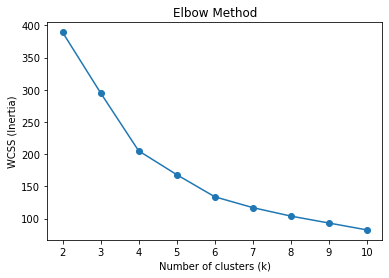

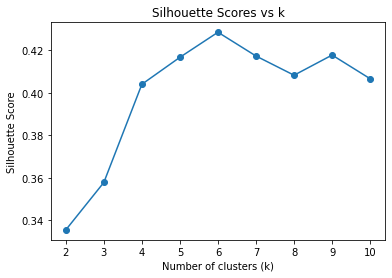

Heuristic best k (silhouette): 6


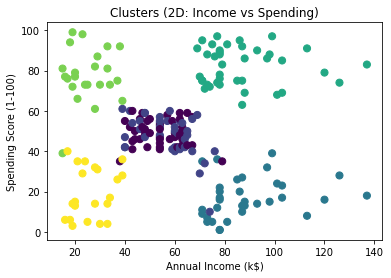

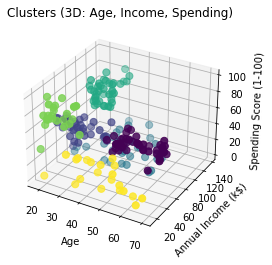

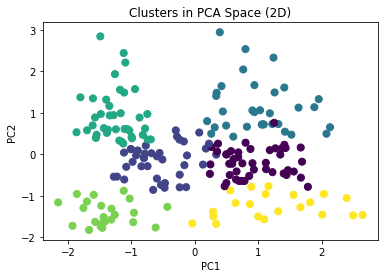

PCA explained variance: PC1=44.27%, PC2=33.31%, Total=77.57%

Cluster sizes:
 0    45
1    39
2    33
3    39
4    23
5    21
Name: Cluster, dtype: int64

Cluster profile (mean/median/min/max):
            Age                Annual Income (k$)                  \
          mean median min max               mean median min  max   
Cluster                                                            
0        56.33   54.0  43  70              54.27   54.0  38   79   
1        26.79   26.0  18  40              57.10   60.0  39   76   
2        41.94   43.0  19  59              88.94   86.0  71  137   
3        32.69   32.0  27  40              86.54   79.0  69  137   
4        25.00   23.0  18  35              25.26   24.0  15   39   
5        45.52   46.0  20  67              26.29   25.0  16   39   

        Spending Score (1-100)                 
                          mean median min max  
Cluster                                        
0                        49.07   49.0  35  60  


In [1]:
# Mall Customer Segmentation — Extended Version
# ---------------------------------------------
# Features: Age, Annual Income (k$), Spending Score (1-100)
# Adds: 3D plots, PCA, k selection (Elbow + Silhouette), cluster profiling

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 (required for 3D)
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

# ------------ 1) Load & inspect ------------
df = pd.read_csv(r"C:\Users\Pranav\Downloads\archive (9).zip")
print("Shape:", df.shape)
print(df.head(3))

# ------------ 2) Feature selection ------------
feat_cols = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']
X = df[feat_cols].copy()

# ------------ 3) Scale features ------------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ------------ 4) Choose k: Elbow + Silhouette ------------
wcss = []
sil_scores = []
K_RANGE = range(2, 11)

for k in K_RANGE:
    km = KMeans(n_clusters=k, init="k-means++", n_init=10, random_state=42)
    km.fit(X_scaled)
    wcss.append(km.inertia_)
    labels = km.labels_
    sil = silhouette_score(X_scaled, labels)
    sil_scores.append(sil)

# Elbow (WCSS)
plt.figure()
plt.plot(list(K_RANGE), wcss, marker='o')
plt.xlabel("Number of clusters (k)")
plt.ylabel("WCSS (Inertia)")
plt.title("Elbow Method")
plt.show()

# Silhouette
plt.figure()
plt.plot(list(K_RANGE), sil_scores, marker='o')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Scores vs k")
plt.show()

# Heuristic pick: max silhouette (or set your own k)
best_k = list(K_RANGE)[int(np.argmax(sil_scores))]
print("Heuristic best k (silhouette):", best_k)

# ------------ 5) Final KMeans fit ------------
kmeans = KMeans(n_clusters=best_k, init="k-means++", n_init=10, random_state=42)
labels = kmeans.fit_predict(X_scaled)
centroids = kmeans.cluster_centers_

df['Cluster'] = labels

# ------------ 6) 2D scatter (Income vs Spending) ------------
plt.figure()
plt.scatter(X['Annual Income (k$)'], X['Spending Score (1-100)'], c=labels, s=50)
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.title('Clusters (2D: Income vs Spending)')
plt.show()

# ------------ 7) 3D scatter (Age, Income, Spending) ------------
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X['Age'], X['Annual Income (k$)'], X['Spending Score (1-100)'], c=labels, s=50)
ax.set_xlabel('Age')
ax.set_ylabel('Annual Income (k$)')
ax.set_zlabel('Spending Score (1-100)')
ax.set_title('Clusters (3D: Age, Income, Spending)')
plt.show()

# ------------ 8) PCA to 2D for visualization ------------
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

plt.figure()
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, s=50)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Clusters in PCA Space (2D)')
plt.show()

explained = pca.explained_variance_ratio_
print(f"PCA explained variance: PC1={explained[0]:.2%}, PC2={explained[1]:.2%}, Total={explained.sum():.2%}")

# ------------ 9) Cluster profiling ------------
profile = (
    df.groupby('Cluster')[feat_cols]
      .agg(['mean', 'median', 'min', 'max'])
      .round(2)
)
counts = df['Cluster'].value_counts().sort_index()
print("\nCluster sizes:\n", counts)
print("\nCluster profile (mean/median/min/max):\n", profile)

# Friendly summary: mean only
mean_profile = df.groupby('Cluster')[feat_cols].mean().round(1)
mean_profile['Count'] = counts
mean_profile = mean_profile.sort_index()
print("\nCluster profile (means + count):\n", mean_profile)

# ------------ 10) Attach human-friendly segment labels (optional) ------------
# Example rule-of-thumb labeling (tweak thresholds per your data distribution)
def label_segment(row):
    inc = row['Annual Income (k$)']; spend = row['Spending Score (1-100)']
    if inc >= df['Annual Income (k$)'].median() and spend >= df['Spending Score (1-100)'].median():
        return "High Income • High Spend"
    if inc >= df['Annual Income (k$)'].median() and spend < df['Spending Score (1-100)'].median():
        return "High Income • Low Spend"
    if inc < df['Annual Income (k$)'].median() and spend >= df['Spending Score (1-100)'].median():
        return "Low Income • High Spend"
    return "Low Income • Low Spend"

segment_lookup = (
    df.groupby('Cluster')[['Annual Income (k$)', 'Spending Score (1-100)']]
      .mean().apply(label_segment, axis=1)
)

df['Segment'] = df['Cluster'].map(segment_lookup.to_dict())
print("\nSegment labels per cluster:\n", segment_lookup)

# Save clustered dataset (optional)
df.to_csv("mall_customers_clustered.csv", index=False)
print("\nSaved: mall_customers_clustered.csv")


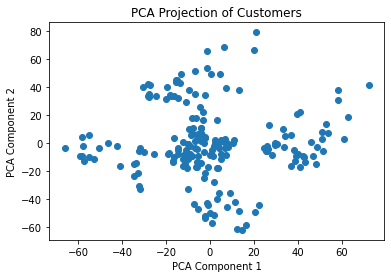

In [2]:
from sklearn.decomposition import PCA

# Using all numerical features
features = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']
X_full = df[features]

# Reduce to 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_full)

# Visualize PCA result
plt.scatter(X_pca[:, 0], X_pca[:, 1])
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA Projection of Customers')
plt.show()


In [5]:
from sklearn.metrics import silhouette_score

# Fit KMeans with optimal k (from elbow method)
optimal_k = 6
kmeans_final = KMeans(n_clusters=optimal_k, init='k-means++', random_state=42)
labels = kmeans_final.fit_predict(X_full)

# Calculate Silhouette Score
score = silhouette_score(X_full, labels)
print(f"Silhouette Score for k={optimal_k}: {score:.3f}")


C:\Users\Pranav\anaconda3\anaconda1\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Silhouette Score for k=6: 0.452


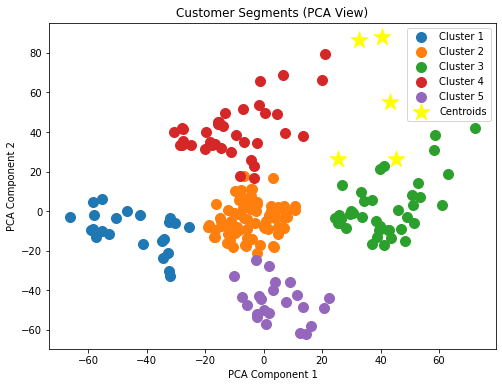

In [4]:
plt.figure(figsize=(8,6))
for i in range(optimal_k):
    plt.scatter(X_pca[labels == i, 0], X_pca[labels == i, 1], s=100, label=f'Cluster {i+1}')

plt.scatter(kmeans_final.cluster_centers_[:, 0], 
            kmeans_final.cluster_centers_[:, 1], 
            s=300, c='yellow', marker='*', label='Centroids')

plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Customer Segments (PCA View)')
plt.legend()
plt.show()
